In [1]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

COLORS = ['r', 'b', 'g', 'y', 'm', 'c', 'orange', 'purple', 'brown', 'teal', 'pink', 'turquoise']

In [2]:
def get_state_space_representation():
    """Get state-space representation of double integrator model."""
    # A, sys.A both have shape (4, 4)
    A = np.diag([1, 1], k=2)
    # B, sys.B both have shape (4, 2)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
    # C has shape (2, 4)
    C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
    # D has shape (2, 2)
    D = np.diag([0, 0])
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), 0.5)
    A = np.array(sys.A)
    B = np.array(sys.B)
    return (A, B)

def make_global_params(p_0_x, p_0_y, v_0_x, v_0_y):
    """Get Global LCSS parameters used across all loops"""
    params = util.AttrDict()
    params.M_big = 1000
    params.A, params.B = get_state_space_representation()
    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    params.nx, params.nu = params.B.shape
    bbox_lon, bbox_lat = 0.6, 0.4
    params.diag = np.sqrt(bbox_lon**2 + bbox_lat**2) / 2.
    # Prediction parameters
    params.T = 8
    params.L = 4 # number of faces of obstacle sets

    # Closed for solution of control without obstacles
    A, B, T, nx, nu = params.A, params.B, params.T, params.nx, params.nu
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    params.Abar = Abar
    params.Bbar = Bbar
    params.Gamma = Gamma

    # x0 : np.array
    #   Initial state
    x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])
    params.p_0_x, params.p_0_y, params.v_0_x, params.v_0_y = x0
    A, T = params.A, params.T
    params.theta = np.angle(v_0_x + 1j*v_0_y)
    # params.v_lim = 8.33
    params.v_lim = 2.5
    # States_free_init has shape (nx*(T+1))
    params.States_free_init = np.concatenate([
            np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
    return params

def compute_velocity_constraints(param, v_x, v_y):
    """Velocity states have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Street speed limit is 30 km/h == 8.33.. m/s"""
    v_lim = param.v_lim # is m/s
    theta = param.theta
    r = v_lim / 2
    v_1 = r
    v_2 = 0.75 * v_lim
    c1 = v_2*((v_x - r*np.cos(theta))*np.cos(theta) \
            + (v_y - r*np.sin(theta))*np.sin(theta))
    c2 = v_1*((v_y - r*np.sin(theta))*np.cos(theta) \
            - (v_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(v_1 * v_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

def compute_acceleration_constraints(param, u_x, u_y):
    """Accelaration control inputs have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Present performance cars are capable of going from 0 to 60 mph in under 5 seconds.
    Reference:
    https://en.wikipedia.org/wiki/0_to_60_mph"""
    theta = param.theta
    r = -2.5
    a_1 = 7.5
    a_2 = 5.0
    c1 = a_2*((u_x - r*np.cos(theta))*np.cos(theta) \
            + (u_y - r*np.sin(theta))*np.sin(theta))
    c2 = a_1*((u_y - r*np.sin(theta))*np.cos(theta) \
            - (u_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(a_1 * a_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

## Problem 1

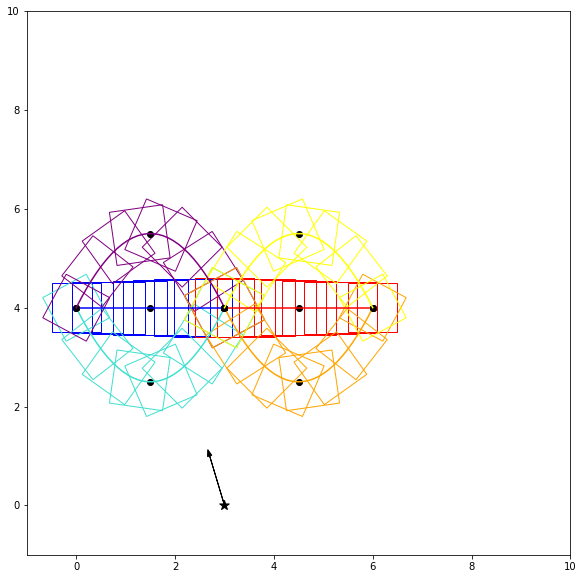

In [19]:
def plot_and_extract_vertices(ax, points, T, color='blue'):
    ax.plot(*points.T, 'ok');
    interp_points = util.interp_and_sample(points, 30)
    ax.plot(*interp_points.T, '-', c=color);
    lws = util.kronecker_mul_vectors(np.array([1., 1.]), np.linspace(1., 1.2, T))
    vertex_set = util.place_rectangles_on_intep_curve(points, T, lws)

    for vertices in vertex_set:
        patch = patches.Polygon(vertices, closed=True, color=color, fc='none')
        ax.add_patch(patch)
    return vertex_set

x0 = np.array([3., 0., -0.3, 1.])
p_0_x, p_0_y, v_0_x, v_0_y = x0
params = make_global_params(p_0_x, p_0_y, v_0_x, v_0_y)
T = params.T
params.O = 2
params.K = np.array([3, 3])
params.N_traj = np.prod(params.K)
fig, ax = plt.subplots(figsize=(10, 10))

points = np.array([
        [0, 4],
        [1.5, 4],
        [3, 4]])
vertex_set_1 = plot_and_extract_vertices(ax, points, T, color='blue')

points = np.array([
        [0, 4],
        [1.5, 2.5],
        [3, 4]])
vertex_set_2 = plot_and_extract_vertices(ax, points, T, color='turquoise')

points = np.array([
        [0, 4],
        [1.5, 5.5],
        [3, 4]])
vertex_set_3 = plot_and_extract_vertices(ax, points, T, color='purple')

points = np.array([
        [6, 4],
        [4.5, 4],
        [3, 4]])
vertex_set_4 = plot_and_extract_vertices(ax, points, T, color='red')

points = np.array([
        [6, 4],
        [4.5, 2.5],
        [3, 4]])
vertex_set_5 = plot_and_extract_vertices(ax, points, T, color='orange')

points = np.array([
        [6, 4],
        [4.5, 5.5],
        [3, 4]])
vertex_set_6 = plot_and_extract_vertices(ax, points, T, color='yellow')

ax.scatter(p_0_x, p_0_y, marker='*', c='k', s=100)
ax.arrow(p_0_x, p_0_y, v_0_x, v_0_y, color='k', head_width=0.09)

ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])

vertex_superset = [
        [    # OV 1
            vertex_set_1,
            vertex_set_2,
            vertex_set_3
        ], [ # OV 2
            vertex_set_4,
            vertex_set_5,
            vertex_set_6
        ]]

N_traj, T, O = params.N_traj, params.T, params.O
A_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
b_unions = np.empty((N_traj, T, O,), dtype=object).tolist()
traj_idx = 0
for _vertex_set_1 in vertex_superset[0]:
    for _vertex_set_2 in vertex_superset[1]:
        for t in range(T):
            for ov_idx, _vertices in enumerate([
                    _vertex_set_1[t], _vertex_set_2[t]]):
                
                A, b = util.vertices_to_halfspace_representation(_vertices)
                A_unions[traj_idx][t][ov_idx] = A
                b_unions[traj_idx][t][ov_idx] = b
        traj_idx += 1

In [31]:
"""Apply motion planning problem"""
goal_x, goal_y = 3, 4
N_coincide = 1
N_traj, L, T, K, O, Gamma, nu, nx = params.N_traj, params.L, params.T, params.K, \
        params.O, params.Gamma, params.nu, params.nx
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-8., ub=8., name='control'))
Delta = np.array(model.binary_var_list(O*L*N_traj*T, name='delta')).reshape(N_traj, T, O, L)

# U has shape (N_traj, T*nu)
U = u.reshape(N_traj, -1)
# Gamma has shape (nx*(T + 1), nu*T) so X has shape (N_traj, nx*(T + 1))
X = util.obj_matmul(U, Gamma.T)
# X, U have shapes (N_traj, T, nx) and (N_traj, T, nu) resp.
X = (X + params.States_free_init).reshape(N_traj, -1, nx)[..., 1:, :]
U = U.reshape(N_traj, -1, nu)

for _U, _X in zip(U, X):
    # _X, _U have shapes (T, nx) and (T, nu) resp.
    p_x, p_y = _X[..., 0], _X[..., 1]
    v_x, v_y = _X[..., 2], _X[..., 3]
    u_x, u_y = _U[..., 0], _U[..., 1]
    model.add_constraints(compute_velocity_constraints(params, v_x, v_y))
    model.add_constraints(compute_acceleration_constraints(params, u_x, u_y))

# set up obstacle constraints
M_big, N_traj, T, diag = params.M_big, params.N_traj, params.T, params.diag
for n in range(N_traj):
    # for each obstacle/trajectory
    A_union, b_union = A_unions[n], b_unions[n]
    for t in range(T):
        # for each timestep
        As, bs = A_union[t], b_union[t]
        for o, (A, b) in enumerate(zip(As, bs)):
            lhs = util.obj_matmul(A, X[n,t,:2]) + M_big*(1 - Delta[n,t,o])
            rhs = b + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[n,t,o]) >= 1)

# set up coinciding constraints
for t in range(0, N_coincide):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# start from current vehicle position and minimize the objective
p_0_x, p_0_y, T, N_traj = params.p_0_x, params.p_0_y, params.T, params.N_traj
goal = np.array([goal_x, goal_y])
cost = 0.
for n in range(N_traj):
    for t in range(T):
        cost += (X[n, t,0] - goal_x)**2 + (X[n, t,1] - goal_y)**2
        cost += 0.05*t*(X[n, t,2]**2 + X[n, t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

# Nodefile size = 1474.66 MB (593.63 MB after compression)


Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIQP Presolve eliminated 151 rows and 105 columns.
MIQP Presolve modified 1692 coefficients.
Aggregator did 6 substitutions.
Reduced MIQP has 1171 rows, 609 columns, and 8204 nonzeros.
Reduced MIQP has 465 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1152 nonzeros.
Presolve time = 0.01 sec. (3.59 ticks)
Probing fixed 12 vars, tightened 0 bounds.
Probing time = 0.00 sec. (3.94 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 12 rows and 12 columns.
MIQP Presolve modified 405 coefficients.
Aggregator did 3 substitutions.
Reduced MIQP has 1156 rows, 594 columns, and 8126 nonzeros.
Reduced MIQP has 450 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 1152 nonzeros.
Presolve time = 0.00 sec. (2.76 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.00

 130467     0      144.8172   133      169.6842      Cuts: 58   641671   10.47%
 130467     0      144.8172   133      169.6842      Cuts: 42   641723   10.47%
 130467     0      144.8172   133      169.6842      Cuts: 27   641755   10.47%
 130467     2      144.8172   190      169.6842      151.9105   641755   10.47%
 135132  2896      156.1602   104      169.6842      151.9105   660902   10.47%
 150202 15607      160.6268    87      169.6842      151.9105   737102   10.47%
 166610 27546      166.0478    79      169.6842      151.9105   808638   10.47%
 182861 41306      157.6913    98      169.6842      151.9105   886940   10.47%
 198042 52177      166.3540    76      169.6842      151.9105   950286   10.47%
 211063 64408      156.3753   127      169.6842      151.9105  1054354   10.47%
 224011 72832      151.6801   144      169.6842      151.9105  1139078   10.47%
 237359 82546      168.3693    74      169.6842      151.9105  1239688   10.47%
Elapsed time = 32.15 sec. (24122.57 tick

 1853445 1180566      164.9583   122      169.6842      156.0100 12695591    8.06%
 1905804 1213170      158.8972   102      169.6842      156.0726 13075303    8.02%
 1958438 1245919      167.5597    86      169.6842      156.1265 13464718    7.99%
 2013248 1281297      165.5936    84      169.6842      156.1826 13861079    7.96%
 2067806 1319335      164.2220   140      169.6842      156.2269 14260641    7.93%
 2121443 1356854      158.2903   119      169.6842      156.2642 14671392    7.91%
 2176161 1391353      165.9971   117      169.6842      156.3018 15027202    7.89%
 2229240 1432233      167.4703    82      169.6842      156.3332 15471555    7.87%
 2283087 1464775      163.6030    86      169.6842      156.3654 15810578    7.85%
Elapsed time = 262.06 sec. (170040.26 ticks, tree = 785.78 MB, solutions = 74)
 2336516 1505075      167.0365    60      169.6842      156.3997 16239425    7.83%
 2390535 1539188      169.0154    77      169.6842      156.4317 16612355    7.81%
*2395088

 6289969 3308067      167.1495    82      167.7655      158.2347 43648859    5.68%
 6347132 3344185      158.2575    99      167.7655      158.2497 44035149    5.67%
 6395932 3370162      166.7461    80      167.7655      158.2658 44312613    5.66%
 6453932 3401329      162.8038    97      167.7655      158.2800 44618773    5.65%
Elapsed time = 751.18 sec. (474280.60 ticks, tree = 1808.51 MB, solutions = 81)
 6504929 3437996      166.7755   138      167.7655      158.2956 44988181    5.64%
 6561011 3473490      163.4388    82      167.7655      158.3083 45345097    5.64%
 6613417 3512033      163.5754    84      167.7655      158.3232 45732996    5.63%
 6668540 3543813      161.0750    85      167.7655      158.3365 46049362    5.62%
 6725676 3570061      161.7673    88      167.7655      158.3526 46290816    5.61%
 6778043 3603398      163.6014    74      167.7655      158.3655 46603665    5.60%
 6833789 3645240      167.3733    55      167.7655      158.3797 47025556    5.59%
 688367

 10832924 6074560        cutoff            167.7655      159.1624 72405348    5.13%
 10887481 6119676      166.3262    63      167.7655      159.1710 72863484    5.12%
 10941130 6146751        cutoff            167.7655      159.1789 73130549    5.12%
 10999438 6186342      162.1950    75      167.7655      159.1890 73516649    5.11%
 11051794 6218472      167.5105    85      167.7655      159.1959 73804991    5.11%
 11108998 6254522      166.7387    90      167.7655      159.2055 74140288    5.10%
 11156345 6288145      162.6715    86      167.7655      159.2126 74523159    5.10%
 11211241 6309894      167.1785    66      167.7655      159.2200 74767771    5.09%
Elapsed time = 1390.10 sec. (817609.58 ticks, tree = 3230.70 MB, solutions = 81)
Nodefile size = 1181.72 MB (479.66 MB after compression)
 11258844 6344832      164.4489    90      167.7655      159.2291 75151420    5.09%
 11312308 6371272      161.5502    88      167.7655      159.2374 75451020    5.08%
 11361499 6406132     

In [35]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta

AttributeError: 'numpy.float64' object has no attribute 'solution_value'

In [33]:
X_star.shape

(9, 8, 4)

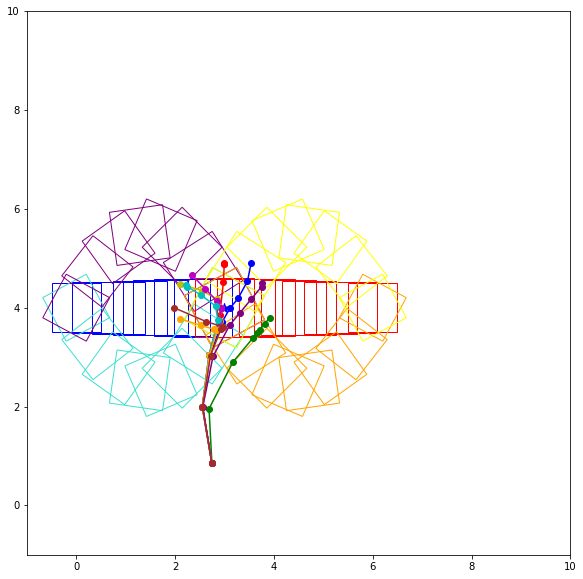

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='turquoise', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='purple', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='red', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='orange', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_6:
    patch = patches.Polygon(vertices, closed=True, color='yellow', fc='none')
    ax.add_patch(patch)

for n in range(N_traj):
    _X = X_star[n, :, :2]
    ax.plot(*_X.T, '-o', color=COLORS[n])
ax.scatter(*goal, marker='*', s=100, c='b')
ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None

## Problem 2

In [ ]:
"""Apply motion planning problem"""
N_select = 5
goal_x, goal_y = 3, 4
N_coincide = 1
subtraj_indices = np.random.choice(np.arange(params.N_traj), size=N_select, replace=False)
N_traj, L, T, K, O, Gamma, nu, nx = params.N_traj, params.L, params.T, params.K, \
        params.O, params.Gamma, params.nu, params.nx
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
u = np.array(model.continuous_var_list(N_select*T*nu, lb=-8., ub=8., name='control'))
Delta = np.array(model.binary_var_list(O*L*N_select*T, name='delta')).reshape(N_select, T, O, L)

# U has shape (N_select, T*nu)
U = u.reshape(N_select, -1)
# Gamma has shape (nx*(T + 1), nu*T) so X has shape (N_select, nx*(T + 1))
X = util.obj_matmul(U, Gamma.T)
# X, U have shapes (N_select, T, nx) and (N_select, T, nu) resp.
X = (X + params.States_free_init).reshape(N_select, -1, nx)[..., 1:, :]
U = U.reshape(N_select, -1, nu)

for _U, _X in zip(U, X):
    # _X, _U have shapes (T, nx) and (T, nu) resp.
    p_x, p_y = _X[..., 0], _X[..., 1]
    v_x, v_y = _X[..., 2], _X[..., 3]
    u_x, u_y = _U[..., 0], _U[..., 1]
    model.add_constraints(compute_velocity_constraints(params, v_x, v_y))
    model.add_constraints(compute_acceleration_constraints(params, u_x, u_y))

# set up obstacle constraints
M_big, T, diag = params.M_big, params.T, params.diag
for n, i in enumerate(subtraj_indices):
    # select outerapprox. by index i
    A_union, b_union = A_unions[i], b_unions[i]
    for t in range(T):
        # for each timestep
        As, bs = A_union[t], b_union[t]
        for o, (A, b) in enumerate(zip(As, bs)):
            lhs = util.obj_matmul(A, X[n,t,:2]) + M_big*(1 - Delta[n,t,o])
            rhs = b + diag
            model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
            model.add_constraint(np.sum(Delta[n,t,o]) >= 1)

# set up coinciding constraints
for t in range(0, N_coincide):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# start from current vehicle position and minimize the objective
p_0_x, p_0_y, T = params.p_0_x, params.p_0_y, params.T
goal = np.array([goal_x, goal_y])
cost = 0.
for n in range(N_select):
    for t in range(T):
        cost += (X[n, t,0] - goal_x)**2 + (X[n, t,1] - goal_y)**2
        cost += 0.05*t*(X[n, t,2]**2 + X[n, t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()


In [ ]:
f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)
U_warmstart = U
Delta_warmstart = Delta
X_star.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='b', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_2:
    patch = patches.Polygon(vertices, closed=True, color='turquoise', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_3:
    patch = patches.Polygon(vertices, closed=True, color='purple', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_4:
    patch = patches.Polygon(vertices, closed=True, color='red', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_5:
    patch = patches.Polygon(vertices, closed=True, color='orange', fc='none')
    ax.add_patch(patch)
for vertices in vertex_set_6:
    patch = patches.Polygon(vertices, closed=True, color='yellow', fc='none')
    ax.add_patch(patch)

for n in range(N_traj):
    _X = X_star[n, :, :2]
    ax.plot(*_X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')
ax.set_aspect('equal')
ax.set_xlim([-1, 10])
ax.set_ylim([-1, 10])
None